# Active Continuous DA from GTA5 to Cityscapes

This notebook performs active sample selection using MADA and generalizes the vgg16-deeplabv3 from source to target.

```
conda create --prefix /global/cscratch1/sd/saksman/accda_conda/ --file MAS.txt
conda activate /global/cscratch1/sd/saksman/accda_conda
pip install tensorflow==2.2 imageio umap matplotlib faiss-gpu tensorflow-addons==0.9.1
python3 -m ipykernel install --user --name=accda
```

In [1]:
# End-End training and testing of the new pytorch-based VGG16-deeplabv3 architecture
# https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="8" # set based on how many GPUs you are using

# https://stackoverflow.com/questions/56008683/could-not-create-cudnn-handle-cudnn-status-internal-error
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
# tf.compat.v1.enable_eager_execution()
import importlib
import matplotlib.pyplot as plt
# import wasserstein_utils
import data_utils
import losses
import networks
import deeplabv3 as dlv3
import utils
import pickle
import time
import numpy as np

import data_utils
import losses

from IPython import display
import umap

In [2]:
backbone = 'vgg16'
dataset = "GTA5"

# H x W x C
img_shape = (512,1024,3)

# 19 classes + void
num_classes = 20

batch_size=4

# Testing replay buffer => training off
do_training = False

epochs=250
epoch_step=250

num_projections=100


source_data_dir = './processed-data/1024x512/19_classes/' + dataset + '/train/'
cityscapes_data_dir = './processed-data/1024x512/19_classes/CITYSCAPES/train/'
cityscapes_val_dir = './processed-data/1024x512/19_classes/CITYSCAPES/val/'

fn_w_dlv3 = "weights/" + dataset + "/" + backbone + "_deeplabv3.h5"
fn_w_cls = "weights/" + dataset + "/" + backbone + "_deeplabv3_classifier.h5"

fn_w_adapted_dlv3 = "weights/" + dataset + "/" + backbone +"_deeplabv3_adapted.h5"
fn_w_adapted_cls = "weights/" + dataset + "/" + backbone + "_deeplabv3_classifier_adapted.h5"

## Step 1: Model Construction

This builds a customized deeplabv3 model with classifier layer

In [3]:
importlib.reload(losses)

deeplabv3 = dlv3.deeplabv3(activation=None, \
                           backbone=backbone, \
                           num_classes=num_classes)

X = deeplabv3.input
Y = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], num_classes,), dtype='float32', name='label_input')

C_in = tf.keras.layers.Input(shape=deeplabv3.layers[-1].output_shape[1:], dtype='float32', name='classifier_input')
classifier = tf.keras.Model(C_in, networks.classifier_layers(C_in, num_classes = num_classes, activation='softmax'))

# A combined model, giving the output of classifier(deeplabv3(X))
combined = tf.keras.Model(X, classifier(deeplabv3(X)))
combined.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False))

# A model outputting hxwx1 labels for each image. Also useful to verify the
# mIoU with Keras' built-in function. Will however also consider the 'ignore' class. 
combined_ = tf.keras.Model(X, tf.cast(tf.keras.backend.argmax(combined(X), axis=-1), 'float32'))
combined_.compile(metrics=[tf.keras.metrics.MeanIoU(num_classes=num_classes)])

# Set up training
opt = tf.keras.optimizers.Adam(lr=1e-4, epsilon=1e-8, decay=1e-6)
# opt = tf.keras.optimizers.SGD(lr=1e-4, momentum=.9)

loss_function = losses.weighted_ce_loss(num_classes, 0)
wce_loss = loss_function(Y, classifier(deeplabv3(X)), from_logits=False)

# https://stackoverflow.com/questions/55434653/batch-normalization-doesnt-have-gradient-in-tensorflow-2-0
params = deeplabv3.trainable_weights + classifier.trainable_weights

updates = opt.get_updates(wce_loss, params)

train = tf.keras.backend.function(inputs=[X,Y], outputs=[wce_loss], updates=updates)

In [4]:
deeplabv3.load_weights(fn_w_dlv3)
classifier.load_weights(fn_w_cls)

### Model Summary
This final `combined_` model is consists of (deeplabv3 + classifer). More specifically, `combined` outputs categorical cross entroy and `combined_` outputs Height * Weight * 1 labels.

In [5]:
combined_.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 1024, 3)]    0         
_________________________________________________________________
model_2 (Model)              (None, 512, 1024, 20)     19446008  
_________________________________________________________________
tf_op_layer_ArgMax (TensorFl [(None, 512, 1024)]       0         
_________________________________________________________________
tf_op_layer_Cast (TensorFlow [(None, 512, 1024)]       0         
Total params: 19,446,008
Trainable params: 19,442,424
Non-trainable params: 3,584
_________________________________________________________________


## Step 2: Training on Source Domain

This step can be skipped by loading pretrained model weights.

In [5]:
importlib.reload(data_utils)
import matplotlib.pyplot as plt

# Training on source domain
if do_training == True:
    
    try:
        deeplabv3.load_weights(fn_w_dlv3)
        classifier.load_weights(fn_w_cls)
        print("Successfully loaded model. Continuing training.")
    except:
        print("Could not load previous model weights. Is a new model present?")
        
    start_time = time.time()

    fig,ax = plt.subplots(1,figsize=(10,7))

    loss_history = []
    
    for itr in range(epochs):
        
        source_train_data, source_train_labels = utils.sample_batch(source_data_dir, batch_size=batch_size, seed=itr)
        source_train_labels = tf.keras.utils.to_categorical(source_train_labels, num_classes=num_classes)

        loss_history.append(train(inputs=[source_train_data, source_train_labels]))
        
        if np.isnan(np.sum(loss_history[-1])):
            print('ERROR. ENCOUNTERED NAN')
            break

        if itr%epoch_step == 0:
            if itr != 0:
                ax.clear()
                ax.plot(np.asarray(loss_history))

            ax.set_title("Training loss on source domain")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")

            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(1e-3)
            
        if itr % (epochs // 10) == 0 or itr == epochs - 1:
            deeplabv3.save_weights(fn_w_dlv3)
            classifier.save_weights(fn_w_cls)

    training_time = time.time() - start_time
    
else:   
    deeplabv3.load_weights(fn_w_dlv3)
    classifier.load_weights(fn_w_cls)
    print("Loaded model weights from weights folder")

Loaded model weights from weights folder


In [ ]:
import utils
importlib.reload(utils)

start_time = time.time()

source_cat_iou,source_miou = utils.compute_miou(source_data_dir, combined_, data_utils.label_ids_19, 0)

for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)

# road 0.8559070065772992
# sidewalk 0.9043721610536399
# building 0.8381948427759653
# wall 0.632677142340526
# fence 0.699526703820766
# pole 0.6073661307913504
# traffic light 0.7258756809296298
# traffic sign 0.6789546854786402
# vegetation 0.8526590005209183
# terrain 0.7779495588027171
# sky 0.9530645387149239
# person 0.7316948194592244
# rider 0.809945935261575
# car 0.5922120101790109
# truck 0.9211600020912953
# bus 0.9270433021188236
# train 0.8659149467023691
# motorcycle 0.6754852581619956
# bicycle 0.5876167577346231
# 0.7704010780797522
# Computed GTA5 mIoU in 1953.6462309360504

In [ ]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils.label_ids_19, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed CITYSCAPES mIoU in', time.time() - start_time)

# road 0.4538541445555259
# sidewalk 0.17761519682584992
# building 0.5960010633542256
# wall 0.11064090337021892
# fence 0.08225737548235189
# pole 0.11701661235497808
# traffic light 0.2131517695419058
# traffic sign 0.085832471689785
# vegetation 0.7016830692115976
# terrain 0.05272756739697445
# sky 0.4267235195286716
# person 0.30570697364634025
# rider 0.03181916445284627
# car 0.4930313336164962
# truck 0.05910168795933546
# bus 0.052471835602942996
# train 0.003952731749887269
# motorcycle 0.07819570698033228
# bicycle 0.0073530220468457285
# 0.2131124289140585
# Computed CITYSCAPES mIoU in 249.57955932617188

### Active Learning: Feature Map Generation and Centroids Clustering

This step generates a feature map from the source dataset. It then clusters the features into centroids. 

In [10]:
deeplabv3.summary() # This is the freezed feature encode f_E

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1024, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 1024, 64 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 1024, 64 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 512, 64) 0           block1_conv2[1][0]               
______________________________________________________________________________________________

### Feature Map Generation
Feature encoder f_E (deeplabv3), calculate the feature map Fc(x) of a source sample x for a certain categorty c. y_c denotes the label map for category c. Square multiply denotes element wise multiplication for extraction of categorty-exclusive information. |A_c| is the number of pixels belonging to the specific category. 

![feature map formula](images/feature-formula.png)

The final feature vector F(x) of the source x is obtained by first flattening the F_c(x) of each categroty into a vector, and then connect vectors of all categories into a long vector. 

In [10]:
def calculate_mean_vector(images, labels, vector_size):
    n = len(images)
    full_objective_vector = np.zeros([n, 20, vector_size]) 
    for image, label in zip(images, labels):
        image = np.expand_dims(image, axis=0)
        f_E = deeplabv3(image)[0, :, :, :]
        F_x = np.zeros((20, vector_size)) # feature map for this image
        for c in range(0,19): # 20 classes
            F_c_x = tf.math.multiply(f_E[:,:,c], label[:,:,c]) / np.sum(label[:,:,c])
            F_c_x_expanded = np.expand_dims(np.expand_dims(F_c_x, axis=0), axis=3)
            F_c_x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(32, 64), padding='valid')(F_c_x_expanded)
            F_c_x = tf.reshape(F_c_x, [-1])
            F_x[c] = F_c_x
        full_objective_vector[n-1, :] = F_x[:]
    return full_objective_vector

In [11]:
seed = 123
source_train_data, source_train_labels = utils.sample_batch(source_data_dir, batch_size=50, seed=seed)
source_train_labels = tf.keras.utils.to_categorical(source_train_labels, num_classes=num_classes)
vector_size = 256
full_objective_vector = calculate_mean_vector(source_train_data, source_train_labels, vector_size)

In summary, the feature generation step should look like:
```python
# shape = (number of images, (10 x vector size))
full_objective_vector = np.zeros([len(source_data), 20, vector_size]) 
for i_iter, image, label in source_data:
    f_E = deeplabv3(image)
    F_x = np.zeros(20, vector_size) # feature map for this image
    for c in range(0,19): # 20 classes
        F_c_x = tf.math.multiply(f_E[:,:,:,c], label[:,:,:,c]) / np.sum(label[:,:,:,c])
        F_c_x = tf.reshape(F_c_x, [-1])
        F_x[c] = F_c_x
    full_objective_vector[i_iter, :] = F_x[:]
```
The `full_objective_vector` is the feature map on the entire dataset. It can be saved to a file to later usages. 

### Clustering Anchors

After we have the full_objective_vector, we use the k-means method to group feature vectors of all source images into **k** clusters. 

![cluster-formula](images/cluster-formula.png)

The A_k is the centroid of cluster Ck. It is the source domain anchor, against which the target images will be compared for active sample selection. 

![anchor-formula](images/anchor-formula.png)

In [12]:
import faiss

def run_kmeans(x, nmb_clusters, weighted=False, verbose=False):
    """Runs kmeans on 1 GPU.
    Args:
        x: data
        nmb_clusters (int): number of clusters
        weighted: bool, indicates whether to use weighted K-means
    Returns:
        list: ids of data in each cluster
    """
    n_data, d = x.shape
    
    def H(x):
    '''Calculate entropy of a float'''
        return -(x * np.log(x)).sum()

    # faiss implementation of k-means
    clus = faiss.Clustering(d, nmb_clusters)

    # Change faiss seed at each k-means so that the randomly picked
    # initialization centroids do not correspond to the same feature ids
    # from an epoch to another.
    clus.seed = np.random.randint(1234)

    clus.niter = 20
    clus.max_points_per_centroid = 10000000
    res = faiss.StandardGpuResources()
    flat_config = faiss.GpuIndexFlatConfig()
    flat_config.useFloat16 = False
    flat_config.device = 0
    index = faiss.GpuIndexFlatL2(res, d, flat_config)

    print(x.shape)
    if weighted:
        weights = H(x)
        clus.train(x, index, weights=weights)
    else:
        clus.train(x, index)

    _, I = index.search(x, 1)
    # losses = faiss.vector_to_array(clus.obj)
    stats = clus.iteration_stats
    losses = np.array([
        stats.at(i).obj for i in range(stats.size())
    ])
    if verbose:
        print('k-means loss evolution: {0}'.format(losses))
    centroids = faiss.vector_float_to_array(clus.centroids)

    return centroids, [int(n[0]) for n in I], losses[-1]

In [13]:
np.random.seed(123)
ncentroids = 10
tensor_sample = np.nan_to_num(np.reshape(full_objective_vector, (full_objective_vector.shape[0], full_objective_vector.shape[1] * full_objective_vector.shape[2])).astype('float32'), nan=0.0)
cluster_centroids, cluster_index, cluster_loss = run_kmeans(tensor_sample, ncentroids, weighted=False, verbose=True)
with open('./anchors/cluster_centroids_full_%d.pkl' % ncentroids,'wb') as f: 
    pickle.dump(cluster_centroids, f)

(50, 5120)
k-means loss evolution: [1.85341321e-06 1.81607629e-06 2.27373675e-13 2.27373675e-13
 2.27373675e-13 2.27373675e-13 2.27373675e-13 2.27373675e-13
 2.27373675e-13 2.27373675e-13 2.27373675e-13 2.27373675e-13
 2.27373675e-13 2.27373675e-13 2.27373675e-13 2.27373675e-13
 2.27373675e-13 2.27373675e-13 2.27373675e-13 2.27373675e-13]


In [ ]:
# # weighted K-means
# def calculate_mean_vector(images, labels, vector_size):
#     n = len(images)
#     full_objective_vector = np.zeros([n, 20, vector_size]) 
#     for image, label in zip(images, labels):
#         image = np.expand_dims(image, axis=0)
#         f_E = deeplabv3(image)[0, :, :, :]
#         F_x = np.zeros((20, vector_size)) # feature map for this image
#         for c in range(0,19): # 20 classes
#             F_c_x = tf.math.multiply(f_E[:,:,c], label[:,:,c]) / np.sum(label[:,:,c])
#             F_c_x_expanded = np.expand_dims(np.expand_dims(F_c_x, axis=0), axis=3)
#             F_c_x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(32, 64), padding='valid')(F_c_x_expanded)
#             F_c_x = tf.reshape(F_c_x, [-1])
#             F_x[c] = F_c_x
#         full_objective_vector[n-1, :] = F_x[:]
#     return full_objective_vector

# np.random.seed(123)
# seed = 123
# source_train_data, source_train_labels = utils.sample_batch(source_data_dir, batch_size=50, seed=seed)
# source_train_labels = tf.keras.utils.to_categorical(source_train_labels, num_classes=num_classes)
# vector_size = 256
# full_objective_vector = calculate_mean_vector(source_train_data, source_train_labels, vector_size)

# ncentroids = 10
# tensor_sample = np.nan_to_num(np.reshape(full_objective_vector, (full_objective_vector.shape[0], full_objective_vector.shape[1] * full_objective_vector.shape[2])).astype('float32'), nan=0.0)
# cluster_centroids, cluster_index, cluster_loss = run_kmeans(tensor_sample, ncentroids, weighted=False, verbose=True)
# with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d_weighted.pkl' % ncentroids,'wb') as f: 
#     pickle.dump(cluster_centroids, f)

## Step 3: Loading Replay Buffer

Load the replay buffer from the source data, which stores a portion of previously seen data.

In [5]:
import replay_buffer_utils as rb_utils

start_time = time.time()
source_domain_portion = 0.1
replay_buffer = rb_utils.replay_buffer(source_data_dir, source_domain_portion)
print(time.time() - start_time)
print(replay_buffer.capacity)

4993
534.1320450305939
4993


## Step 4: Continous adaptation to the target domain

Set up the train/loss computation on target domain and perform training

In [6]:
# importlib.reload(wasserstein_utils)
import tensorflow_addons as tfa

Z_s = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], 3,) )
X_labeled = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], 3,) )
Y_s = tf.keras.backend.placeholder(shape=(None, img_shape[0], img_shape[1], num_classes), dtype='float32') # labels of input images oneHot
Y_labeled = tf.keras.backend.placeholder(shape=(None, img_shape[0], img_shape[1], num_classes), dtype='float32') # labels of input images oneHot
lambda1 = 0.1
lambda2 = 5e-1
lambda3 = 0.9

loss_function = losses.weighted_ce_loss(num_classes, 0)
wce_loss_labeled = loss_function(Y_labeled, classifier(deeplabv3(X_labeled)), from_logits=False)
wce_loss_unlabeled = loss_function(Y_s, classifier(deeplabv3(Z_s)), from_logits=False)

# Wasserstein matcing loss
# theta = tf.keras.backend.placeholder(shape = (num_projections, num_classes), dtype='float32')
# matching_loss = wasserstein_utils.sWasserstein_hd(deeplabv3(X), deeplabv3(Z_s), theta, nclass=num_classes, Cp=None, Cq=None,)

# Overall loss is a weighted combination of the losses
# total_loss = lambda1 * wce_loss_unlabeled + lambda2 * matching_loss + lambda3 * wce_loss_labeled
total_loss = lambda1 * wce_loss_unlabeled + lambda3 * wce_loss_labeled

params = deeplabv3.trainable_weights + classifier.trainable_weights

# Optimizer and training setup
# opt = tf.keras.optimizers.Adam(lr=1e-4, epsilon=1e-6, decay=1e-6)
# use SGD w/ weight decay
opt = tfa.optimizers.SGDW(learning_rate=0.0001, momentum=0.9, weight_decay=2.0e-4, name='SGDW')

updates = opt.get_updates(total_loss, params)
train = tf.keras.backend.function(inputs=[X, Z_s, Y_s, X_labeled, Y_labeled], 
                                  outputs=[total_loss, wce_loss_labeled, wce_loss_unlabeled], updates=updates)

In [7]:
loss = []
target_miou = []

deeplabv3.load_weights(fn_w_dlv3)
classifier.load_weights(fn_w_cls)

## Active target sample selection against source anchors

In this adaptation to target step, we should perform the active sample selection, using the following formula.

![target-sample-selection](images/target-sample-selection.png)

In [8]:
import heapq

def get_active_mada_XY(images, pred_labels, actual_labels, vector_size, sampling_rate):
    ''' calculate MADA active learning criteria per image / predicted label and return subset of images / labels for training '''
    al_list = []
    n = len(images)

    # below code is similar to calculate_mean_vector function
    full_objective_vector = np.zeros([n, 20, vector_size]) 
    for image, label in zip(images, pred_labels):
        image = np.expand_dims(image, axis=0)
        f_E = deeplabv3(image)[0, :, :, :]
        F_x = np.zeros((20, vector_size)) # feature map for this image
        for c in range(0,19): # 20 classes
            F_c_x = tf.math.multiply(f_E[:,:,c], label[:,:,c]) / np.sum(label[:,:,c])
            F_c_x_expanded = np.expand_dims(np.expand_dims(F_c_x, axis=0), axis=3)
            F_c_x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(32, 64), padding='valid')(F_c_x_expanded)
            F_c_x = tf.reshape(F_c_x, [-1])
            F_x[c] = F_c_x
        # calculate active learning criteria
        loss = []
        for centroid in cluster_centroids:
            new_loss = np.nanmean((F_x - centroid) ** 2) # TODO: figure out why NaNs, probably resize
            loss.append(new_loss)
        min_loss = min(loss)
        al_list.append(min_loss)
    selected_n = int(sampling_rate * n)
    # find idx vals with smallest loss 
    selected_idx = list(map(al_list.index, heapq.nlargest(selected_n, al_list)))

    # return subset of images / labels for training
    X_labeled = []
    Y_labeled = []
    for idx in selected_idx:
        X_labeled.append(images[idx])
        Y_labeled.append(actual_labels[idx])
        
    X_eval = np.delete(images, selected_idx, 0)
    Y_eval = np.delete(actual_labels, selected_idx, 0)
        
    return np.asarray(X_labeled), np.asarray(Y_labeled), X_eval, Y_eval, selected_idx

In [ ]:
# import heapq

# ncentroids = 10
# with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d_target.pkl' % ncentroids, 'rb') as f: 
#     cluster_centroids = pickle.load(f)
# cluster_centroids = cluster_centroids.reshape(ncentroids, 20, 256)


# def get_active_ours_XY(images, pred_labels, actual_labels, vector_size, sampling_rate):
#     ''' calculate MADA active learning criteria per image / predicted label and return subset of images / labels for training '''
#     al_list = []
#     n = len(images)

#     # below code is similar to calculate_mean_vector function
#     full_objective_vector = np.zeros([n, 20, vector_size]) 
#     for image, label in zip(images, pred_labels):
#         image = np.expand_dims(image, axis=0)
#         f_E = deeplabv3(image)[0, :, :, :]
#         F_x = np.zeros((20, vector_size)) # feature map for this image
#         for c in range(0,19): # 20 classes
#             F_c_x = tf.math.multiply(f_E[:,:,c], label[:,:,c]) / np.sum(label[:,:,c])
#             F_c_x_expanded = np.expand_dims(np.expand_dims(F_c_x, axis=0), axis=3)
#             F_c_x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(32, 64), padding='valid')(F_c_x_expanded)
#             F_c_x = tf.reshape(F_c_x, [-1])
#             F_x[c] = F_c_x
#         # calculate active learning criteria
#         loss = []
#         for centroid in cluster_centroids:
#             new_loss = np.nanmean((F_x - centroid) ** 2) # TODO: figure out why NaNs, probably resize
#             loss.append(new_loss)
#         min_loss = min(loss)
#         al_list.append(min_loss)
#     selected_n = int(sampling_rate * n)
#     # find idx vals with smallest loss 
#     selected_idx = list(map(al_list.index, heapq.nlargest(selected_n, al_list)))

#     # return subset of images / labels for training
#     X_labeled = []
#     Y_labeled = []
#     for idx in selected_idx:
#         X_labeled.append(images[idx])
#         Y_labeled.append(actual_labels[idx])
        
#     X_eval = np.delete(images, selected_idx, 0)
#     Y_eval = np.delete(actual_labels, selected_idx, 0)
        
#     return np.asarray(X_labeled), np.asarray(Y_labeled), X_eval, Y_eval, selected_idx

In [19]:
# test active learning method for a batch of target samples
# load + preprocess source centroids
ncentroids = 10
with open('./anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, 20, 256)

seed = 123
target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=5, seed=seed)
pred_target_labels = deeplabv3(target_train_data)
vector_size = 256

X_labeled, Y_labeled, X_eval, Y_eval = get_active_mada_XY(target_train_data, pred_target_labels, target_train_labels, vector_size, 0.4)
Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)

mIoU at 25 epochs: 0.4871674587852077, best mIoU: 0.5384267631329989
mIoU at 26 epochs: 0.44155036148272064, best mIoU: 0.5384267631329989


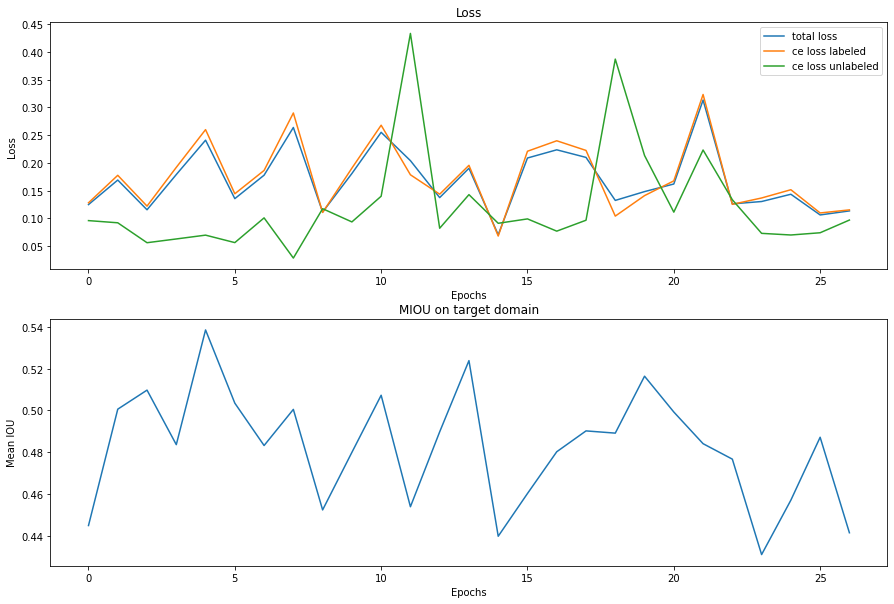

In [ ]:
# ------------------ # test #10 mada w/o wasserstein loss, SGD instead of Adam optimizer, 0.1 replay buffer, 0.9 active learning
# w/ active learning #         batch size = 20, AL sampling rate = 10%, 50 epochs
# ------------------ #
import replay_buffer_utils as rb_utils
import math

start_time = time.time()

fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 20

thres = .99
epochs2 = 50
epochstep = 2

ncentroids = 10

with open('./anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, 20, 256)

best_miou = -math.inf
best_ious = []
for itr in range(epochs2):
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    
    # active learning 
    seed = 123
    pred_target_labels = deeplabv3(target_train_data)
    # select N target images for labeling
    X_labeled, Y_labeled, X_eval, Y_eval, selected_idx = get_active_mada_XY(target_train_data, pred_target_labels, target_train_labels, 256, 0.1)
    Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
    
    ###   replay buffer photo version    
    X, Y = rb_utils.random_sample_replay(replay_buffer, 1)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    # theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    loss.append(train(inputs=[target_train_data, X, Y, X_labeled, Y_labeled]))
    ###   replay buffer photo version ends here
    
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 20/19
    target_miou.append(miou)
    
    if miou > best_miou:
        best_miou = miou
        best_combined = combined_
    
    print("mIoU at {0} epochs: {1}, best mIoU: {2}".format(itr, miou, best_miou)) 

    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss labeled')
            ax[0].plot(ll[:,2], label='ce loss unlabeled')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3)
        
    if itr == epochs2:
        # run for best epoch
        best_cat_iou, best_miou2 = utils.compute_miou(cityscapes_data_dir, best_combined, data_utils.label_ids_19, ids_to_ignore = selected_idx)
        for k in best_cat_iou:
            print(k, best_cat_iou[k])
        print(best_miou2)
    
print(time.time() - start_time)

KeyboardInterrupt: 

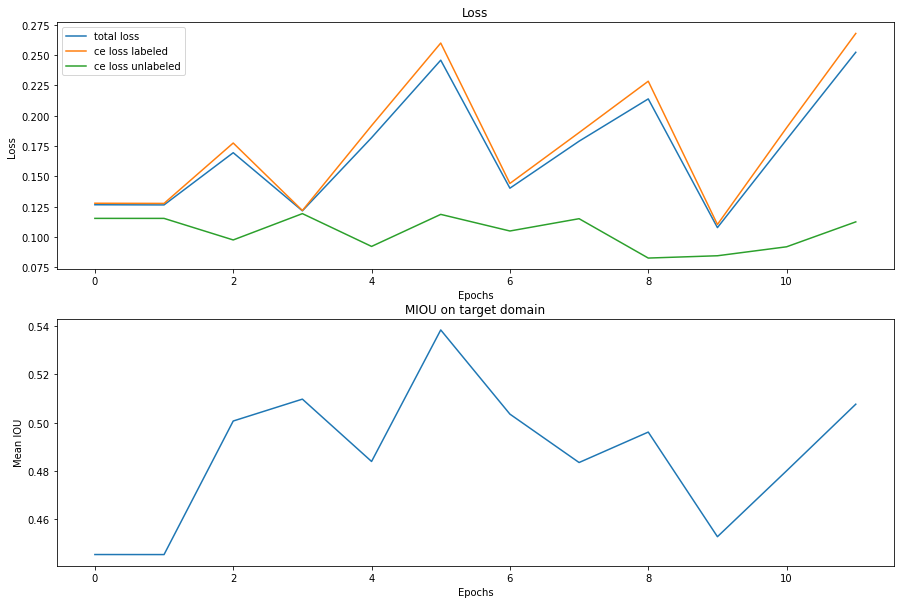

In [14]:
# ------------------ # test #9 mada w/o wasserstein loss, SGD instead of Adam optimizer, 0.1 replay buffer, 0.9 active learning
# w/ active learning #         batch size = 20, AL sampling rate = 10%, 50 epochs
# ------------------ #
import replay_buffer_utils as rb_utils
import math

start_time = time.time()

fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 20

thres = .99
epochs2 = 50
epochstep = 2

ncentroids = 10

with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, 20, 256)

best_miou = -math.inf
best_ious = []
for itr in range(epochs2):
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    
    # active learning 
    seed = 123
    pred_target_labels = deeplabv3(target_train_data)
    # select N target images for labeling
    X_labeled, Y_labeled, X_eval, Y_eval, selected_idx = get_active_mada_XY(target_train_data, pred_target_labels, target_train_labels, 256, 0.1)
    Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
    
    ###   replay buffer photo version    
    X, Y = rb_utils.random_sample_replay(replay_buffer, 1)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    # theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    loss.append(train(inputs=[target_train_data, X, Y, X_labeled, Y_labeled]))
    ###   replay buffer photo version ends here
    
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 20/19
    target_miou.append(miou)
    
    if miou > best_miou:
        best_miou = miou
        best_combined = combined_
    
    print("mIoU at {0} epochs: {1}, best mIoU: {2}".format(itr, miou, best_miou)) 

    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss labeled')
            ax[0].plot(ll[:,2], label='ce loss unlabeled')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3)
        
    if itr == epochs2:
        # run for best epoch
        best_cat_iou, best_miou2 = utils.compute_miou(cityscapes_data_dir, best_combined, data_utils.label_ids_19, ids_to_ignore = selected_idx)
        for k in best_cat_iou:
            print(k, best_cat_iou[k])
        print(best_miou2)
    
print(time.time() - start_time)

KeyboardInterrupt: 

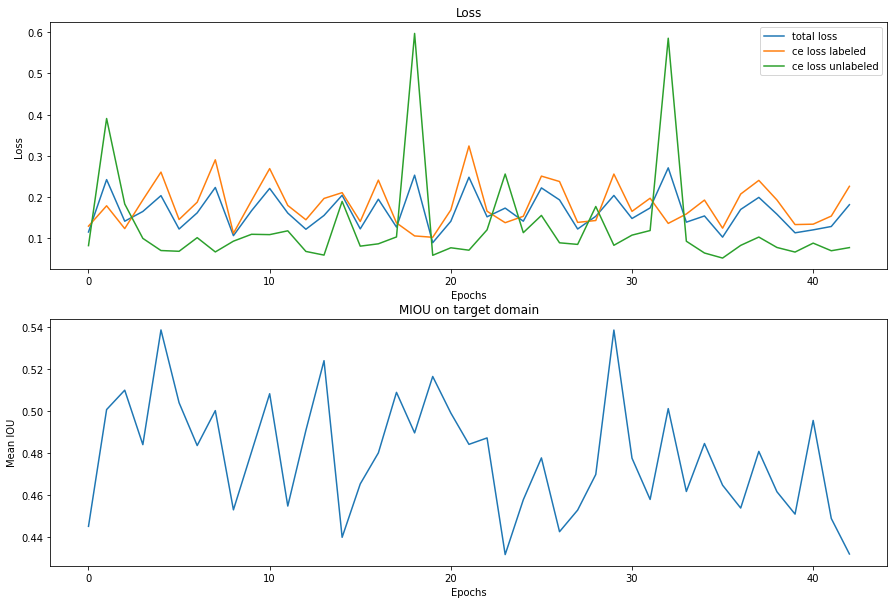

In [12]:
# ------------------ # test #8 mada w/o wasserstein loss, SGD instead of Adam optimizer, 0.3 unlabeled, 0.7 labeled
# w/ active learning #         batch size = 20, AL sampling rate = 10%, 50 epochs
# ------------------ #
import replay_buffer_utils as rb_utils
import math

start_time = time.time()

fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 20

thres = .99
epochs2 = 50
epochstep = 2

ncentroids = 10

best_miou = -math.inf

with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, 20, 256)

for itr in range(epochs2):
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    
    # active learning 
    seed = 123
    pred_target_labels = deeplabv3(target_train_data)
    # select N target images for labeling
    X_labeled, Y_labeled, X_eval, Y_eval = get_active_mada_XY(target_train_data, pred_target_labels, target_train_labels, 256, 0.1)
    Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
    
    ###   replay buffer photo version    
    X, Y = rb_utils.random_sample_replay(replay_buffer, 1)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    # theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    loss.append(train(inputs=[target_train_data, X, Y, X_labeled, Y_labeled])) # 5 labels, 50 X, Y, theta_instance pseudolabels. Only use 45  X, Y, theta_instance pseudolabels
    ###   replay buffer photo version ends here
    
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 20/19
    target_miou.append(miou)
    
    if miou > best_miou:
        best_miou = miou
    
    print("mIoU at {0} epochs: {1}, best mIoU: {2}".format(itr, miou, best_miou)) 

    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss labeled')
            ax[0].plot(ll[:,2], label='ce loss unlabeled')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3)
    
print(time.time() - start_time)

KeyboardInterrupt: 

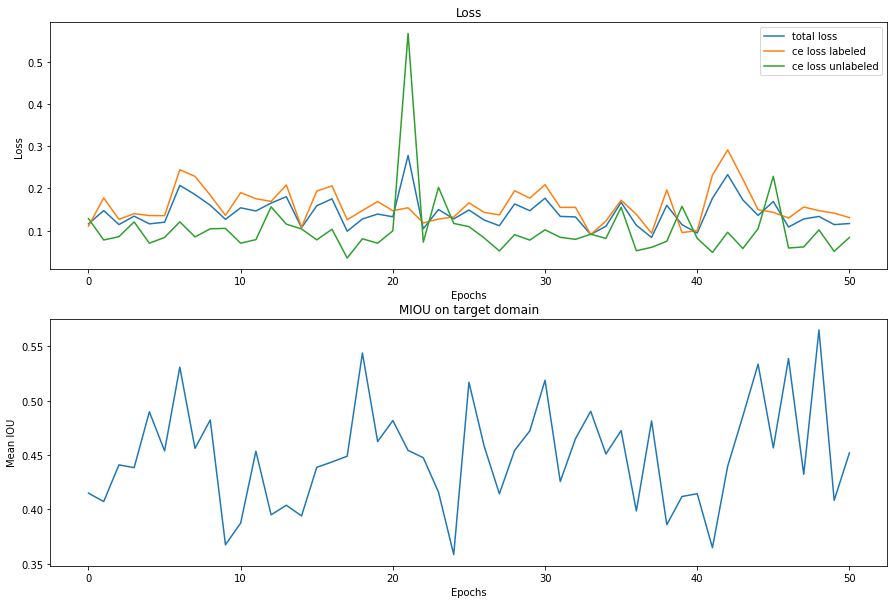

In [11]:
# ------------------ # test #7 mada w/o wasserstein loss, SGD instead of Adam optimizer, 0.3 unlabeled, 0.7 labeled
# w/ active learning #
# ------------------ #
import replay_buffer_utils as rb_utils
start_time = time.time()


fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 5

thres = .99
epochs2 = 500
epochstep = 2

ncentroids = 10
with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, 20, 256)

for itr in range(epochs2):
    if (itr % 2 == 0):
        print(itr)
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    
    # active learning 
    seed = 123
    pred_target_labels = deeplabv3(target_train_data)
    # select N target images for labeling
    X_labeled, Y_labeled, X_eval, Y_eval = get_active_mada_XY(target_train_data, pred_target_labels, target_train_labels, 256, 0.4)
    Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
    
    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)
    
    ###   replay buffer photo version    
    X, Y = rb_utils.random_sample_replay(replay_buffer, 1)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    # theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    loss.append(train(inputs=[target_train_data, X, Y, X_labeled, Y_labeled])) # 5 labels, 50 X, Y, theta_instance pseudolabels. Only use 45  X, Y, theta_instance pseudolabels
    ###   replay buffer photo version ends here
    
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 20/19
    target_miou.append(miou)
    print(miou)
    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss labeled')
            ax[0].plot(ll[:,2], label='ce loss unlabeled')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3)
    
print(time.time() - start_time)

KeyboardInterrupt: 

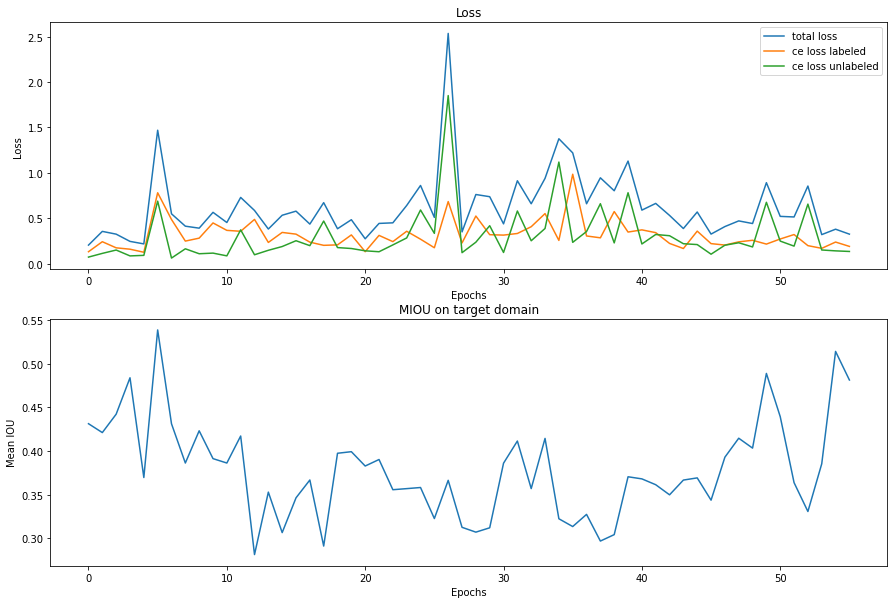

In [15]:
# ------------------ # test #6 mada w/o wasserstein loss
# w/ active learning #
# ------------------ #
import replay_buffer_utils as rb_utils
start_time = time.time()


fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 5

thres = .99
epochs2 = 500
epochstep = 2

ncentroids = 10
with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, 20, 256)

for itr in range(epochs2):
    if (itr % 2 == 0):
        print(itr)
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    
    # active learning 
    seed = 123
    pred_target_labels = deeplabv3(target_train_data)
    # select N target images for labeling
    X_labeled, Y_labeled, X_eval, Y_eval = get_active_mada_XY(target_train_data, pred_target_labels, target_train_labels, 256, 0.4)
    Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
    
    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)
    
    ###   replay buffer photo version    
    X, Y = rb_utils.random_sample_replay(replay_buffer, 1)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    # theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    loss.append(train(inputs=[target_train_data, X, Y, X_labeled, Y_labeled])) # 5 labels, 50 X, Y, theta_instance pseudolabels. Only use 45  X, Y, theta_instance pseudolabels
    ###   replay buffer photo version ends here
    
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 20/19
    target_miou.append(miou)
    print(miou)
    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss labeled')
            ax[0].plot(ll[:,2], label='ce loss unlabeled')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3)
    
print(time.time() - start_time)

In [ ]:
# ------------------ # test #5
# w/ active learning #
# ------------------ #
import replay_buffer_utils as rb_utils
start_time = time.time()


fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 5

thres = .99
epochs2 = 500
epochstep = 2

ncentroids = 10
with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, 20, 256)

for itr in range(epochs2):
    if (itr % 2 == 0):
        print(itr)
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    
    # active learning 
    seed = 123
    pred_target_labels = deeplabv3(target_train_data)
    # select N target images for labeling
    X_labeled, Y_labeled, X_eval, Y_eval = get_active_mada_XY(target_train_data, pred_target_labels, target_train_labels, 256, 0.4)
    Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
    
    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)
    
    ###   replay buffer photo version    
    X, Y = rb_utils.random_sample_replay(replay_buffer, 1)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    # theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    loss.append(train(inputs=[target_train_data, X, Y, X_labeled, Y_labeled])) # 5 labels, 50 X, Y, theta_instance pseudolabels. Only use 45  X, Y, theta_instance pseudolabels
    ###   replay buffer photo version ends here
    
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 20/19
    target_miou.append(miou)
    print(miou)
    if itr%epochstep==2:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss labeled')
            ax[0].plot(ll[:,2], label='ce loss unlabeled')
            ax[0].plot(ll[:,3] * lambda2, label='wasserstein loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3)
    
print(time.time() - start_time)

0
0.41179462483054713
0.37121725709814773
2
0.2971923351287842
0.16885211593226382
4
0.12611896583908483
0.07823974678390905
6
0.09533112770632694
0.0937565847447044
8
0.09273037314414978
0.0747376445092653
10
0.0890619739105827
0.07748972428472418
12
0.1197166427185661
0.06351532120453685
14
0.06838103658274601
0.07925530013285186
16
0.06625591140044362
0.06268291489074104
18
0.08290665714364302
0.05918534962754501
20
0.08814116057596709
0.09218484163284302
22
0.10628812407192431
0.13500204211787173
24
0.1436408569938258
0.10688177849117078
26
0.13235992506930702
0.13250873277061864
28
0.11604255751559608
0.1135297041190298
30
0.1222766543689527
0.1370728329608315
32
0.1444665224928605
0.15244887063377782
34
0.1358843947711744
0.13263595731634842
36
0.18493412356627614
0.14746940449664467
38
0.1556776385558279
0.15966410699643588
40
0.16046128774944105
0.16438498308784083
42
0.14166118283020823
0.16732333522093923
44
0.16283309773394936
0.13563609436938637
46
0.14703838448775441
0.143

KeyboardInterrupt: 

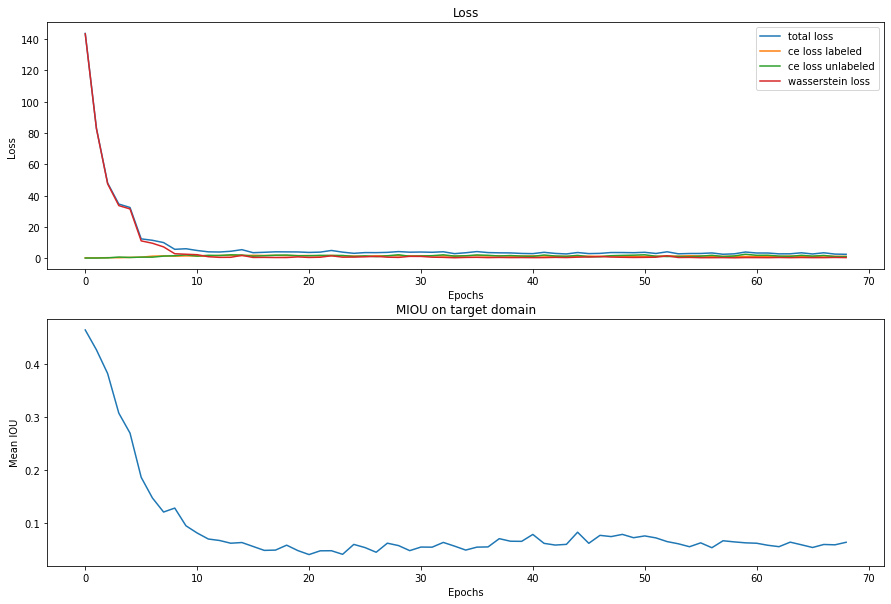

In [10]:
# ------------------ # test #4
# w/ active learning #
# ------------------ #
import replay_buffer_utils as rb_utils
start_time = time.time()


fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 10

thres = .99
epochs2 = 500
epochstep = 2

ncentroids = 10
with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, 20, 256)

for itr in range(epochs2):
    if (itr % 2 == 0):
        print(itr)
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    
    # active learning 
    seed = 123
    pred_target_labels = deeplabv3(target_train_data)
    # select N target images for labeling
    X_labeled, Y_labeled, X_eval, Y_eval = get_active_mada_XY(target_train_data, pred_target_labels, target_train_labels, 256, 0.2)
    Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
    
    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)
    
    ###   replay buffer photo version    
    X, Y = rb_utils.random_sample_replay(replay_buffer, 1)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    loss.append(train(inputs=[target_train_data, X, Y, theta_instance, X_labeled, Y_labeled])) # 5 labels, 50 X, Y, theta_instance pseudolabels. Only use 45  X, Y, theta_instance pseudolabels
    ###   replay buffer photo version ends here
    
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 20/19
    target_miou.append(miou)
    print(miou)
    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss labeled')
            ax[0].plot(ll[:,2], label='ce loss unlabeled')
            ax[0].plot(ll[:,3] * lambda2, label='wasserstein loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3)
    
print(time.time() - start_time)

In [ ]:
# ------------------ # test #3
# w/ active learning #
# ------------------ #
import replay_buffer_utils as rb_utils
start_time = time.time()


fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 20

thres = .99
epochs2 = 500
epochstep = 2

ncentroids = 10
with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, 20, 256)

for itr in range(epochs2):
    if (itr % 2 == 0):
        print(itr)
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    
    # active learning 
    seed = 123
    pred_target_labels = deeplabv3(target_train_data)
    # select N target images for labeling
    X_labeled, Y_labeled, X_eval, Y_eval = get_active_mada_XY(target_train_data, pred_target_labels, target_train_labels, 256, 0.1)
    Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
    
    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)
    
    ###   replay buffer photo version    
    X, Y = rb_utils.random_sample_replay(replay_buffer, 1)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    loss.append(train(inputs=[target_train_data, X, Y, theta_instance, X_labeled, Y_labeled])) # 5 labels, 50 X, Y, theta_instance pseudolabels. Only use 45  X, Y, theta_instance pseudolabels
    ###   replay buffer photo version ends here
    
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 20/19
    target_miou.append(miou)
    print(miou)
    if itr%epochstep==2:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss labeled')
            ax[0].plot(ll[:,2], label='ce loss unlabeled')
            ax[0].plot(ll[:,3] * lambda2, label='wasserstein loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3)
    
print(time.time() - start_time)

0
0.43776923104336385
0.46278733956186396
2
0.3712719992587441
0.27940577582309123
4
0.23464847552148918
0.16968632999219393
6
0.12152845922269319
0.09458310509982862
8
0.08086015519342925
0.05917807550806748
10
0.04649190134123752
0.044428529708009014
12
0.04154861365493975
0.038472155207081846
14
0.03751024211707868
0.04229275019545304
16
0.03679413936640087
0.033875962621287295
18
0.040748762456994304
0.039611721509381345
20
0.038417460102784004
0.03734495686857324
22
0.040727747898352776
0.03891971158353906
24
0.04397685198407424
0.04298309746541475
26
0.04123630100174954
0.04038215075668536
28
0.044176437352833
0.03907655414782072
30
0.03768784043036009
0.040828467983948555
32
0.04210248589515686
0.04256179850352438
34
0.04016365659864325
0.038523646561723
36
0.039524726177516734


4676.14915394783


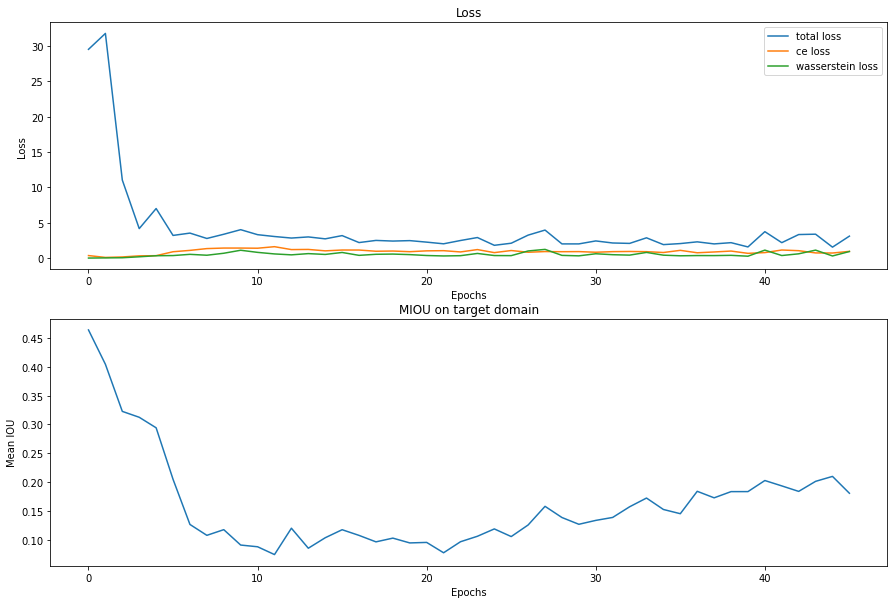

In [28]:
# ------------------ # test #1
# w/ active learning #
# ------------------ #
import replay_buffer_utils as rb_utils
start_time = time.time()


fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 5

thres = .99
epochs2 = 50
epochstep = 5

for itr in range(epochs2):
    if (itr % 5 == 0):
        print(itr)
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    
    # active learning 
    seed = 123
    pred_target_labels = deeplabv3(target_train_data)
    # select N target images for labeling
    X_labeled, Y_labeled, X_eval, Y_eval = get_active_mada_XY(target_train_data, pred_target_labels, target_train_labels, vector_size, 0.4)
    Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)

    # TODO mark remaining indices for evaluation
    
    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)
    
    ###   replay buffer photo version    
    X, Y = rb_utils.random_sample_replay(replay_buffer, 1)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    # print(X.shape)
    # print(Y.shape)
    # loss.append(train(inputs=[target_train_data, X, Y, theta_instance])) # 5 labels, 50 X, Y, theta_instance pseudolabels. Only use 45  X, Y, theta_instance pseudolabels
    loss.append(train(inputs=[target_train_data, X, Y, theta_instance, X_labeled, Y_labeled])) # 5 labels, 50 X, Y, theta_instance pseudolabels. Only use 45  X, Y, theta_instance pseudolabels
    ###   replay buffer photo version ends here
    
    target_miou.append(combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 20/19)
    
    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss')
            ax[0].plot(ll[:,2] * lambda2, label='wasserstein loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3)
    
print(time.time() - start_time)

In [29]:
target_miou

[0.46407517633940043,
 0.40447169228603963,
 0.3227327685607107,
 0.3125143051147461,
 0.2942433482722232,
 0.20487528098256966,
 0.12651449755618446,
 0.10763656151922125,
 0.11748626043922022,
 0.09077401537644236,
 0.08780061414367274,
 0.0742582663109428,
 0.11999107505145826,
 0.08526878137337535,
 0.10344717847673517,
 0.11738800688793785,
 0.10753317883140162,
 0.0963146984577179,
 0.10279574676563866,
 0.09447195812275536,
 0.09534182517152083,
 0.07738903949135228,
 0.09652914969544661,
 0.10600758226294267,
 0.11876395658442848,
 0.1055047543425309,
 0.12562576093171773,
 0.15796052782159103,
 0.138561160940873,
 0.12681401873889722,
 0.1335637506685759,
 0.13869651054081164,
 0.15717187994404844,
 0.1723472695601614,
 0.15251532981270238,
 0.1451612616840162,
 0.18404748878980937,
 0.17272982158158956,
 0.18348414646951774,
 0.18352964991017393,
 0.2027553633639687,
 0.19343929855447067,
 0.18389948104557238,
 0.20132238927640414,
 0.20991416353928416,
 0.1806512475013733,
 

In [ ]:
# ------------------- #
# w/o active learning #
# ------------------- #
# import replay_buffer_utils as rb_utils
# start_time = time.time()


fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 1

thres = .99
epochs2 = 50
epochstep = 5

for itr in range(epochs2):
    if (itr % 5 == 0):
        print(itr)
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    
    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)
    
    ###   replay buffer photo version    
    X, Y = rb_utils.random_sample_replay(replay_buffer, 1)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    # print(X.shape)
    # print(Y.shape)
    loss.append(train(inputs=[target_train_data, X, Y, theta_instance])) # 5 labels, 50 X, Y, theta_instance pseudolabels. Only use 45  X, Y, theta_instance pseudolabels
    ###   replay buffer photo version ends here
    
    target_miou.append(combined_.evaluate(target_train_data, target_train_labels, verbose=False)[-1] * 20/19)
    
    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class 
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss')
            ax[0].plot(ll[:,2] * lambda2, label='wasserstein loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3)
    
print(time.time() - start_time)

In [13]:
import utils
importlib.reload(utils)

start_time = time.time()

source_cat_iou,source_miou = utils.compute_miou(source_data_dir, combined_, data_utils.label_ids_19, 0)

for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)

# road 0.6675523660118785
# sidewalk 0.28336359271439726
# building 0.6076388775470897
# wall 0.2672064026700072
# fence 0.17232300484931942
# pole 0.2735294951039704
# traffic light 0.32147051090247314
# traffic sign 0.07400171986539407
# vegetation 0.5965591779805058
# terrain 0.2889806932148324
# sky 0.8603173835723591
# person 0.3489449704700763
# rider 0.17189785226832072
# car 0.5761907340114261
# truck 0.2955718142857747
# bus 0.14318027819603177
# train 0.033001835642511974
# motorcycle 0.12385339561083183
# bicycle 0.025308995240981697
# 0.3226785842188517
# Computed GTA5 mIoU in 1957.6215891838074

road 0.8969252263565725
sidewalk 0.791973061315036
building 0.6937540331029338
wall 0.3196389810845718
fence 0.48920540623954084
pole 0.5495385742180461
traffic light 0.62543947230715
traffic sign 0.5460324315708157
vegetation 0.8223499398028953
terrain 0.6412613449909258
sky 0.9346188256674707
person 0.6581309194028496
rider 0.4646612500793929
car 0.5383507866421012
truck 0.776287678824603
bus 0.613043302361334
train 0.4435616798465766
motorcycle 0.46090523262007327
bicycle 0.36386763327572585
0.6120813568267691
Computed GTA5 mIoU in 9242.788471460342


In [14]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils.label_ids_19, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed CITYSCAPES mIoU in', time.time() - start_time)

# road 0.7883116582422506
# sidewalk 0.6215464735885322
# building 0.751691007583865
# wall 0.3993120030432491
# fence 0.39173486089325144
# pole 0.302509334397975
# traffic light 0.3019573318279201
# traffic sign 0.38603017233885695
# vegetation 0.7792104073113252
# terrain 0.484321694588526
# sky 0.8323752669785053
# person 0.5206867614087272
# rider 0.2377222662760571
# car 0.8020324193022697
# truck 0.4754062370048565
# bus 0.593789975462107
# train 0.5966522990567177
# motorcycle 0.3119814031424603
# bicycle 0.47793033593638945
# 0.5292211530728338
# Computed CITYSCAPES mIoU in 232.43373942375183

road 0.7294519270466135
sidewalk 0.12274543676326749
building 0.5119485094726066
wall 0.08462184602938219
fence 0.09791119107201429
pole 0.2602157707759973
traffic light 0.1579686966466059
traffic sign 0.061069546117202445
vegetation 0.35594581035067885
terrain 0.12886132128308714
sky 0.3016382816646777
person 0.12176573520736395
rider 0.013707600591330645
car 0.3034960570373347
truck 0.0432615610418868
bus 0.004369816385476659
train 5.9086822487947065e-06
motorcycle 0.06139595578873575
bicycle 0.02287066643255707
0.1780658757046878
Computed CITYSCAPES mIoU in 1087.3808329105377


In [15]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_val_dir, combined_, data_utils.label_ids_19, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed CITYSCAPES mIoU in', time.time() - start_time)

# road 0.7544163600114073
# sidewalk 0.5308953550336675
# building 0.717284542680233
# wall 0.23788752577432637
# fence 0.23876931970965581
# pole 0.30541033061844014
# traffic light 0.26957407403015937
# traffic sign 0.376477515173791
# vegetation 0.7753905145446299
# terrain 0.34884060225349456
# sky 0.7869146824909259
# person 0.4745299170266906
# rider 0.1876271570458875
# car 0.7709355490558467
# truck 0.22249057345069
# bus 0.44033013386788367
# train 0.2018302023064041
# motorcycle 0.14355169668014212
# bicycle 0.48504701470377987
# 0.43516858244516077
# Computed CITYSCAPES mIoU in 41.712018966674805

road 0.7398598351457689
sidewalk 0.13151706321661094
building 0.49606467370112206
wall 0.08829448440694314
fence 0.05638433389146027
pole 0.2820310908664354
traffic light 0.1659301336670999
traffic sign 0.05292539991166199
vegetation 0.37256328634427144
terrain 0.09888383095229418
sky 0.24418270611893134
person 0.1250452976941772
rider 0.01125088433401075
car 0.31327977978717403
truck 0.042247518182627314
bus 0.001444872887055553
train 0.0
motorcycle 0.0491935618799043
bicycle 0.025659172877507377
0.1735135750455293
Computed CITYSCAPES mIoU in 185.74409079551697


In [16]:
deeplabv3.save_weights(fn_w_adapted_dlv3)
classifier.save_weights(fn_w_adapted_cls)